## Khushbu Soni   <div>      Student_id:34113851

# 3  Logistic Regression versus Bayes Classifier

## Q 5
### 5.1 Discriminative vs Generative Models

In [ ]:
from scipy.stats import multivariate_normal
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_breast_cancer
breast_cancer = load_breast_cancer()
x, y = breast_cancer.data, breast_cancer.target

class BayesianClassifier:

    def __init__(self, shared_cov=True, cond_ind=True):
        self.shared_cov=shared_cov
        self.cond_ind=cond_ind

    def fit(self, x, y):
        self.classes_, class_counts = np.unique(y, return_counts=True)
        self.n_ , self.p_ = x.shape
        self.k_ = len(self.classes_)
        self.cond_means_ = np.zeros(shape=(self.k_, self.p_))
        self.cond_covs_ = np.zeros(shape=(self.k_, self.p_, self.p_))

        self.class_priors_ = class_counts/len(y)
        for c in range(self.k_):
            c_rows = y==c
            self.cond_means_[c, :] = x[c_rows].mean(axis=0)
            if self.cond_ind:
                np.fill_diagonal(self.cond_covs_[c, :, :], x[c_rows].var(axis=0))
            else:
                self.cond_covs_[c, :, :] = np.cov(x[c_rows].T, bias=True)

        if self.shared_cov:
            shared_cov = np.moveaxis(self.cond_covs_, 0, -1).dot(self.class_priors_)
            self.cond_covs_[:] = shared_cov

        return self

    def predict_proba(self, x):
        m, _ = x.shape
        cond_probs = np.zeros(shape=(m, self.k_))
        for c in range(self.k_):
            # find p(x | c_k)
            # singular covariance matrices could happen (e.g., through inaccurate estimation)
            cond_probs[:, c] = multivariate_normal.pdf(x,
                                                       self.cond_means_[c],
                                                       self.cond_covs_[c],
                                                       allow_singular=True)
        # find marginal probabilities p(x) by summing all the conditionals weighted by the priors
        marginal_probs = cond_probs.dot(self.class_priors_)

        # find probability vector (p(c1 | x), ..., p(ck | x)) via p(ci | x)=p(x | ci) / p(x)
        # however, p(x) might have been rounded to 0
        # thus, compute via case distinction
        probs = np.divide((cond_probs*self.class_priors_).T,
                          marginal_probs,
                          where=marginal_probs>0, out=np.zeros(shape=(self.k_, m))).T
        return probs

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

    def decision_function(self, x):
        probs = self.predict_proba(x)
        if self.k_ == 2:
            return np.log(probs[:, 1]/probs[:, 0])
        else:
            res = np.zeros(len(x), self.k_)
            for c in range(self.k_):
                res[:, c]=np.log(probs[:, c]/(1-probs[:, c]))
            return res

    def generate(self, n, c, random_state=None):
        return multivariate_normal.rvs(self.cond_means_[c], self.cond_covs_[c], size=n, random_state=random_state)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
breast_cancer = load_breast_cancer()
X, Y = breast_cancer.data, breast_cancer.target

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=0.8, random_state=0)

# Initialize models
logistic_reg = LogisticRegression(max_iter=10000, random_state=0)
naive_bayes = BayesianClassifier(shared_cov=False, cond_ind=True)
bayesian_shared_cov = BayesianClassifier(shared_cov=True, cond_ind=False)
bayesian_full_cov = BayesianClassifier(shared_cov=False, cond_ind=False)

# Store models in a dictionary for easy comparison
model_dict = {
    'Logistic-Regression': logistic_reg,
    'Naive Bayes (Not shared cov)': naive_bayes,
    'Bayesian (Full Cov, Not Shared)': bayesian_full_cov,
    'Bayesian (Full Cov, Shared)': bayesian_shared_cov
}

# Train and evaluate models
for model_name, model_instance in model_dict.items():
    model_instance.fit(X_train, Y_train)
    y_train_pred = model_instance.predict(X_train)
    y_test_pred = model_instance.predict(X_test)
    train_acc = accuracy_score(Y_train, y_train_pred)
    test_acc = accuracy_score(Y_test, y_test_pred)

    print(f"{model_name}")
    print(f" - Train Accuracy: {train_acc:.5f}, \n - Test Accuracy: {test_acc:.5f}")


Logistic-Regression
 - Train Accuracy: 0.96264, 
 - Test Accuracy: 0.94737
Naive Bayes (Not shared cov)
 - Train Accuracy: 0.92967, 
 - Test Accuracy: 0.93860
Bayesian (Full Cov, Not Shared)
 - Train Accuracy: 0.93407, 
 - Test Accuracy: 0.89474
Bayesian (Full Cov, Shared)
 - Train Accuracy: 0.95824, 
 - Test Accuracy: 0.96491


Bayesian (Full Covariance, Shared) has the highest Test Accuracy (96.49%), meaning it generalizes best to unseen data, and the Train Accuracy (95.82%) is also quite high, indicating that it fits the training data well without overfitting.

Logistic Regression also performs well, with a Test Accuracy of 94.74%, but it is slightly worse than the Bayesian (Full Covariance, Shared) model.

Naive Bayes (Not Shared Covariance) has slightly lower performance than both Logistic Regression and Bayesian (Full Covariance, Shared) in terms of both train and test accuracy.

Bayesian (Full Covariance, Not Shared) has the lowest test accuracy (89.47%), indicating that it may be overfitting to the training data.

The Bayesian Classifier with Full Covariance (Shared) performs the best in terms of both train and test accuracy, making it the top-performing model in this comparison.

### 5.2 effect of training size on different models

In [ ]:
import pandas as pd


# Store results
results = {
    'N': [],
    'Model': [],
    'Train Accuracy': [],
    'Test Accuracy': []
}
total_samples = len(y)

# Experiment with increasing training sizes N = 5, 10, ..., up to 500
for N in range(5, 501, 5):
    if N >= total_samples:
        break  # Skip sizes larger than the total number of samples

    for _ in range(10):  # 10 training sets for each N
        # Randomly sample a training set of size N using stratified sampling
        test_size = total_samples - N  # Adjust test size dynamically
        X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=N, test_size=test_size, shuffle=True, stratify=y, random_state=0)

        for model_name, model_instance in model_dict.items():
            # Fit the model
            model_instance.fit(X_train, Y_train)
            # Predict for training and testing data
            y_train_pred = model_instance.predict(X_train)
            y_test_pred = model_instance.predict(X_test)

            # Calculate accuracy
            train_acc = accuracy_score(Y_train, y_train_pred)
            test_acc = accuracy_score(Y_test, y_test_pred)

            # Store results
            results['N'].append(N)
            results['Model'].append(model_name)
            results['Train Accuracy'].append(train_acc)
            results['Test Accuracy'].append(test_acc)

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results)

### 5.3 plots that compare the mean train and test performances of models.

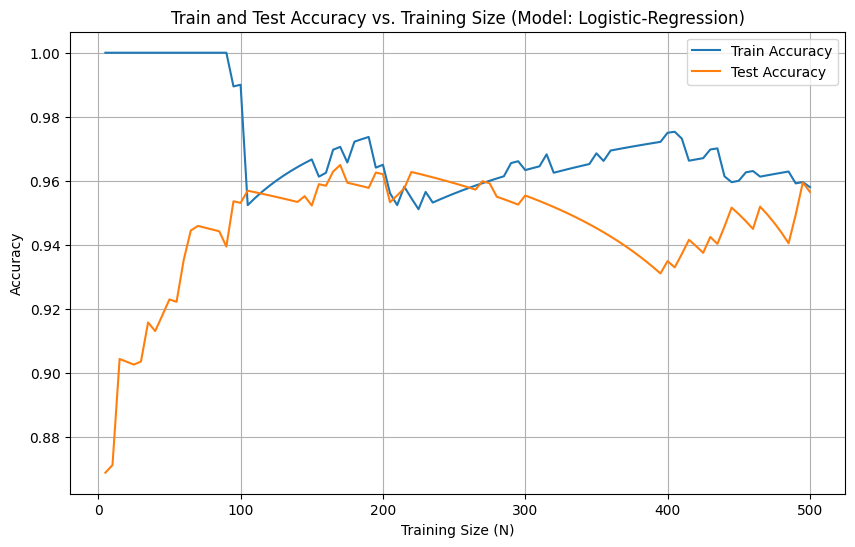

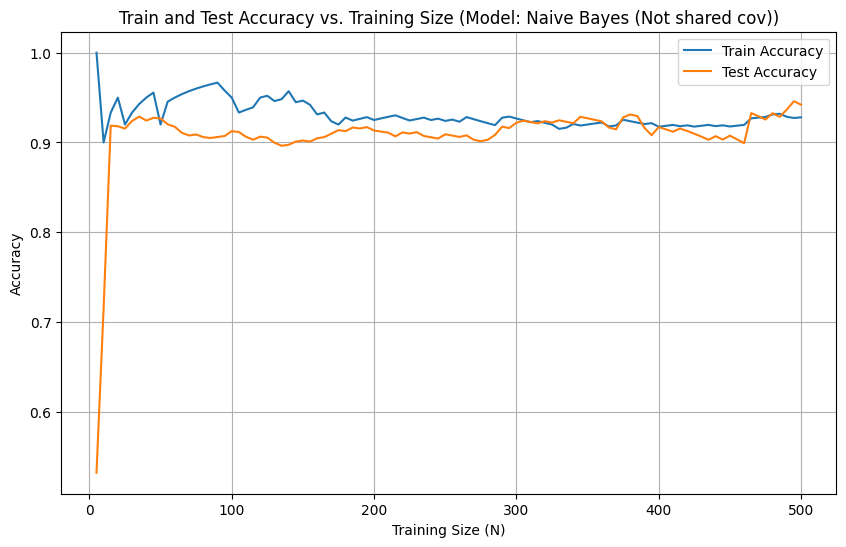

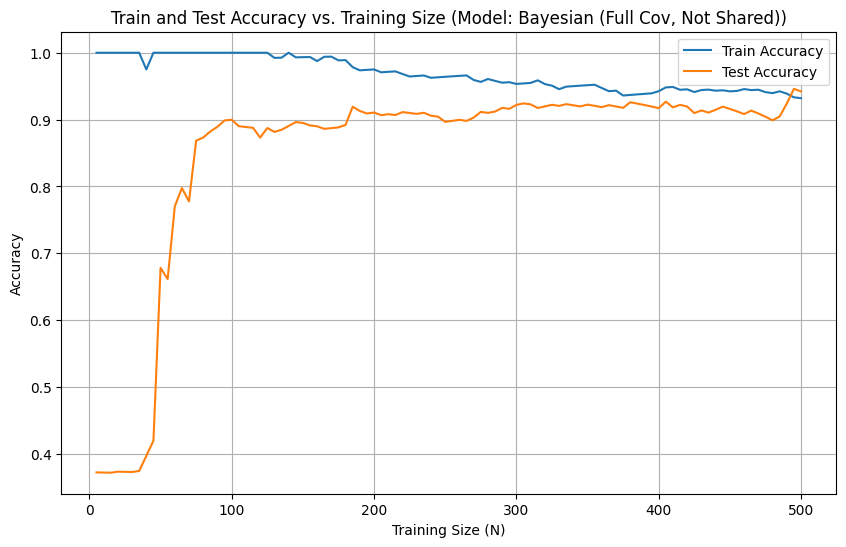

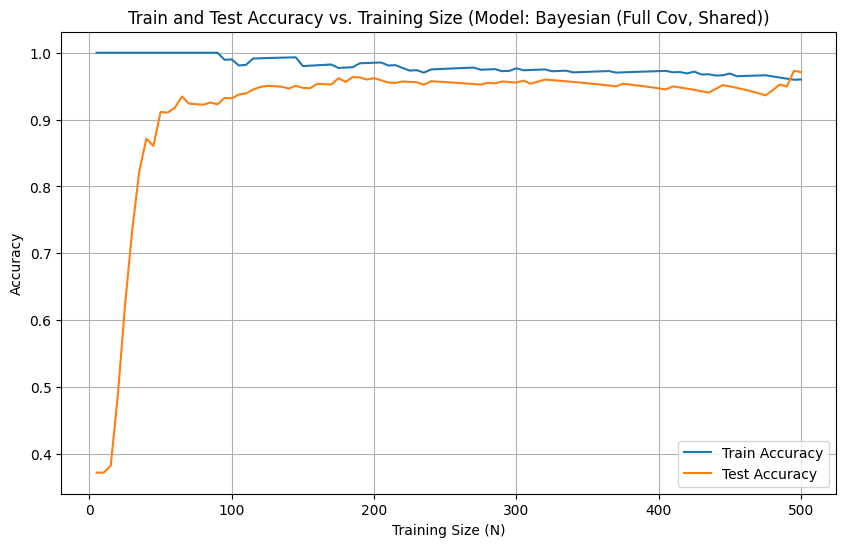

In [ ]:
import matplotlib.pyplot as plt

# Plot training and test accuracy for each model
for model_name in model_dict.keys():
    model_results = results_df[results_df['Model'] == model_name]

    # Group by training size and take the mean accuracy over the 10 samples, only for numeric columns
    model_results_grouped = model_results.groupby('N')[['Train Accuracy', 'Test Accuracy']].mean()

    plt.figure(figsize=(10, 6))
    plt.plot(model_results_grouped.index, model_results_grouped['Train Accuracy'], label='Train Accuracy')
    plt.plot(model_results_grouped.index, model_results_grouped['Test Accuracy'], label='Test Accuracy')
    plt.title(f"Train and Test Accuracy vs. Training Size (Model: {model_name})")
    plt.xlabel("Training Size (N)")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


### 5.4 Justification:

a))
Bayesian Classifier (Full Covariance, Shared):

Train Performance: The training accuracy remains consistently high, near 100%, even as the number of training data points increases.

Test Performance: The test accuracy gradually improves as more training data is provided.

Bayesian Classifier (Full Covariance, Not Shared):

Train Performance: The training accuracy stays high but slightly fluctuates when the training size is small.

Test Performance: The test accuracy improves as the dataset size increases but is consistently lower than the shared covariance model.

Naive Bayes (Not Shared Covariance):

Train Performance: The training accuracy fluctuates a lot for smaller datasets but stabilizes as the training size increases

Test Performance: The test accuracy improves quickly with increasing training size but stays around 91%, even for larger datasets.

Logistic Regression:

Train Performance: The training accuracy decreases gradually as the training size grows.

Test Performance: The test accuracy starts lower and improves steadily, reaching around 94-95% with larger datasets.





b)) Small vs. Large Training Sets:

With smaller datasets, simpler models like Naive Bayes and Bayesian with shared covariance perform well because they rely on fewer parameters, making them less prone to overfitting.

With larger datasets, more flexible models like Logistic Regression and Bayesian (Full Covariance, Shared) take advantage of the available data to generalize better and achieve higher test accuracy

c)) The Bayesian Classifier (Full Covariance, Shared) performs well across all dataset sizes because sharing the covariance matrix reduces overfitting by lowering the complexity of the model, making it effective with smaller datasets. In contrast, the Full Covariance, Not Shared model requires more parameters to estimate, leading to overfitting on smaller datasets and improving only with larger datasets. Naive Bayes works well with smaller datasets due to its strong independence assumption, which simplifies the model, but it struggles when the dataset grows, as the assumption becomes limiting with complex data. Logistic Regression is highly dependent on the dataset size, starting with underfitting in smaller datasets but showing strong generalization with larger data due to its linear structure and robustness. Each model’s performance correlates with its complexity and assumptions, balancing flexibility with the risk of overfitting.